Using device: cuda
Loaded train data size: 60000
Loaded test data size:  10000
Starting training (1 epoch)...
Epoch 1, Average Loss: 0.2235
Epoch 2, Average Loss: 0.0913
Epoch 3, Average Loss: 0.0612
Epoch 4, Average Loss: 0.0462
Epoch 5, Average Loss: 0.0360
Epoch 6, Average Loss: 0.0285
Epoch 7, Average Loss: 0.0221
Epoch 8, Average Loss: 0.0219
Epoch 9, Average Loss: 0.0163
Epoch 10, Average Loss: 0.0178
Training done.

Generating 3 samples for digit '2' using Langevin dynamics...
Sample #1
  Step 20/1000, Energy: 0.0420
  Step 40/1000, Energy: 0.0274
  Step 60/1000, Energy: 0.0191
  Step 80/1000, Energy: 0.0170
  Step 100/1000, Energy: 0.0152
  Step 120/1000, Energy: 0.0144
  Step 140/1000, Energy: 0.0150
  Step 160/1000, Energy: 0.0141
  Step 180/1000, Energy: 0.0080
  Step 200/1000, Energy: 0.0075
  Step 220/1000, Energy: 0.0056
  Step 240/1000, Energy: 0.0051
  Step 260/1000, Energy: 0.0044
  Step 280/1000, Energy: 0.0043
  Step 300/1000, Energy: 0.0031
  Step 320/1000, Energy: 

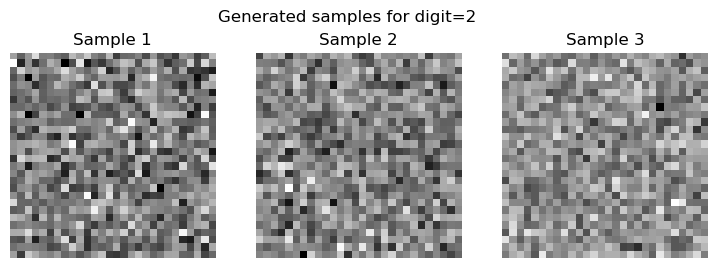

Sample 1 prediction: 2, confidence: 1.00
Sample 2 prediction: 2, confidence: 0.99
Sample 3 prediction: 2, confidence: 1.00


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#######################################
# 1) SETUP: DEVICE + PRINT
#######################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#######################################
# 2) DATASET (MNIST)
#######################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)
print("Loaded train data size:", len(train_data))
print("Loaded test data size: ", len(test_data))

#######################################
# 3) SIMPLE MLP CLASSIFIER
#######################################
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # x shape: [batch, 1, 28, 28]
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleMLP().to(device)

#######################################
# 4) TRAIN THE CLASSIFIER (1 EPOCH DEMO)
#######################################
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("Starting training (1 epoch)...")
model.train()
for epoch in range(10):
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}")
print("Training done.")

#######################################
# 5) ENERGY FUNCTION: E(x) = -log p(y|x)
#######################################
def energy_function(model, x, target_class):
    """
    x: Tensor of shape [1, 1, 28, 28].
    target_class: integer (0..9).
    Returns: scalar (the negative log-likelihood).
    """
    # Forward pass
    logits = model(x)
    log_probs = F.log_softmax(logits, dim=1)
    # We pick the log-prob of 'target_class'
    return -log_probs[0, target_class]

#######################################
# 6) LANGEVIN SAMPLING
#######################################
def langevin_sampling(model, target_class=0, steps=100, step_size=0.01, noise_scale=0.005):
    """
    Use gradient-based MCMC (Langevin Dynamics) to sample an image x
    from the unnormalized density E(x) = -log p(target_class | x).

    Returns a single image of shape [1, 1, 28, 28].
    """
    # 6.1) Initialize x to random noise on the same device as model
    x = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)
    
    for i in range(steps):
        # Zero-out gradient from previous step
        if x.grad is not None:
            x.grad.zero_()
        
        # Compute energy
        e = energy_function(model, x, target_class)
        
        # Backprop to get gradient
        e.backward()
        
        # Langevin update:
        with torch.no_grad():
            # x <- x - step_size * grad + noise
            x = x - step_size * x.grad + noise_scale * torch.randn_like(x)
        
        # Detach from graph to avoid accumulating history
        x = x.detach()
        x.requires_grad_()
        
        # (Optional) print intermediate status
        if (i+1) % 20 == 0:
            print(f"  Step {i+1}/{steps}, Energy: {e.item():.4f}")

    return x.detach()

#######################################
# 7) GENERATE MULTIPLE SAMPLES & CHECK
#######################################
model.eval()

# Example: generate some samples for digit '2'
target_digit = 2
num_samples  = 3
print(f"\nGenerating {num_samples} samples for digit '{target_digit}' using Langevin dynamics...")

sample_images = []
for s in range(num_samples):
    print(f"Sample #{s+1}")
    sample_x = langevin_sampling(model, target_class=target_digit,
                                 steps=1000, step_size=0.01, noise_scale=0.01)
    sample_images.append(sample_x)

print("Sampling complete!")

#######################################
# 8) PLOT GENERATED SAMPLES
#######################################
plt.figure(figsize=(9, 3))
for i, img_tensor in enumerate(sample_images):
    # Move to CPU for plotting
    img = img_tensor[0].cpu().numpy().squeeze()  # shape [28, 28]
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle(f"Generated samples for digit={target_digit}")
plt.show()

#######################################
# 9) HOW TO CHECK IF IN-DISTRIBUTION?
#######################################
# Quick check: see if the classifier predicts the intended digit
# with high confidence. (Not a perfect test, but a start.)
for i, img_tensor in enumerate(sample_images):
    with torch.no_grad():
        logits = model(img_tensor)
        probs  = F.softmax(logits, dim=1)
        pred_class = probs.argmax(dim=1).item()
        pred_conf  = probs[0, pred_class].item()
        print(f"Sample {i+1} prediction: {pred_class}, confidence: {pred_conf:.2f}")
